## Training a Neural Network

#### Load and preprocess the data

Importing required libraries

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, pandas as pd, sklearn.datasets
from pathlib import Path

import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler


In [2]:
DATADIR = Path.home()/'data'
DATADIR.mkdir(exist_ok=True)
DATADIR

WindowsPath('C:/Users/prebe/data')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),         # Convert images to tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizing with mean and std of MNIST
])

## MNISt dataset
train = datasets.MNIST(root=DATADIR, train=True, download=True, transform=transform)
test = datasets.MNIST(root=DATADIR, train=True, download=True, transform=transform)


In [4]:
fraction = 0.025
train_subset_size = int(len(train) * fraction)
test_subset_size  = int(len(test) * fraction)

# Generate random indices for the train and test sets
train_indices = np.random.choice(len(train), train_subset_size, replace=False)
test_indices = np.random.choice(len(test), test_subset_size, replace=False)

# Indices refers to a sequence of integers
# that are used to specify which elements in the dataset should be included in the sample when the DataLoader iterates through the dataset. 
# These indices are essentially the positions or the order numbers of the dataset entries.

# Create SubsetRandomSampler instances
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(train, batch_size=64, sampler=train_sampler)
test_loader = DataLoader(test, batch_size=64, sampler=test_sampler)

Image 0 - Shape: torch.Size([1, 28, 28])


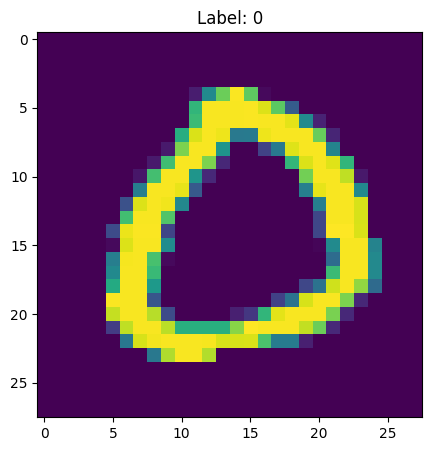

In [5]:
import matplotlib.pyplot as plt

# Get a batch of training data
images, labels = next(iter(train_loader))

# Function to show an image
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Show images with dimensions

print(f"Image {0} - Shape: {images[0].size()}")
imshow(images[0], f"Label: {labels[0]}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


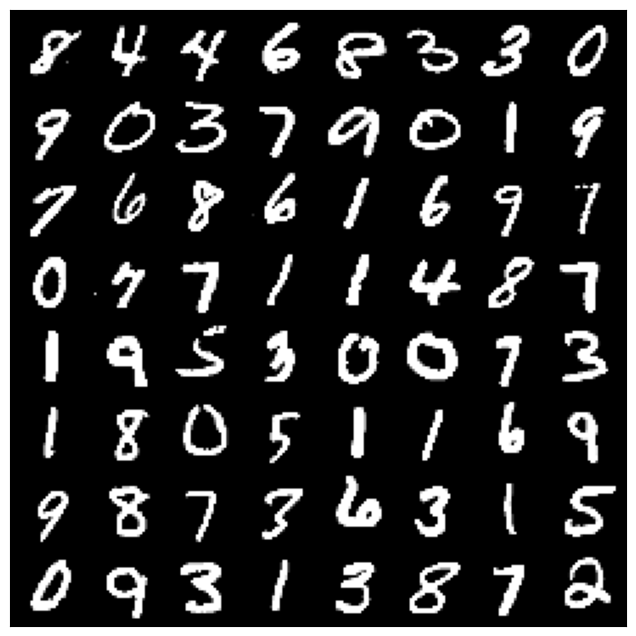

In [6]:
def show_images(images, labels, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

# Display some images
for images, labels in train_loader:
    show_images(images, labels)
    break

### Step 1. Initlization

### Update
1. Adding more hidden layers

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.flatten = nn.Flatten()  # Flatten the 28x28 images to 784-dimensional vectors
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128),  # First layer from 784 inputs to 128 hidden neurons
            nn.ReLU(),              # Activation function for non-linearity
            nn.Dropout(0.5),        # Dropout to prevent overfitting
            nn.Linear(128, 64),     # Second hidden layer
            nn.ReLU(),              # Activation function for non-linearity
            nn.Linear(64, 32),      # Third hidden layer
            nn.ReLU(),              # Activation function for non-linearity
            nn.Linear(32, 10)       # Output layer from 32 hidden neurons to 10 outputs
        )

    def forward(self, x):
        x = self.flatten(x)        # Flatten the image
        logits = self.linear_relu_stack(x)  # Pass through the network
        return logits


#### Network structure

In [8]:
model = Network()
model

Network(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=10, bias=True)
  )
)

#### Weights and biases (parameters)

In [9]:
weights_and_biases = model.parameters()
list(weights_and_biases)

[Parameter containing:
 tensor([[-0.0207, -0.0188,  0.0350,  ..., -0.0248,  0.0331,  0.0091],
         [ 0.0009,  0.0038,  0.0036,  ..., -0.0327, -0.0150, -0.0254],
         [ 0.0058,  0.0073, -0.0333,  ...,  0.0036, -0.0299, -0.0159],
         ...,
         [ 0.0176, -0.0154, -0.0054,  ..., -0.0058,  0.0152, -0.0023],
         [-0.0011,  0.0259, -0.0052,  ..., -0.0021, -0.0102,  0.0167],
         [ 0.0312, -0.0216,  0.0244,  ..., -0.0197,  0.0276,  0.0006]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0147, -0.0229, -0.0307, -0.0131,  0.0090, -0.0005,  0.0194,  0.0100,
          0.0094,  0.0166, -0.0006,  0.0093, -0.0032, -0.0191,  0.0146, -0.0083,
         -0.0138,  0.0329,  0.0049,  0.0253, -0.0144,  0.0108,  0.0054,  0.0011,
          0.0289,  0.0129, -0.0079,  0.0290, -0.0172,  0.0133,  0.0032, -0.0111,
          0.0353, -0.0198,  0.0194,  0.0348,  0.0242,  0.0209,  0.0050, -0.0124,
          0.0078, -0.0257, -0.0283, -0.0159, -0.0294,  0.0048,  0.0005,  0.0077

## 3. Initialize model, loss function and optimizer

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Network().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

## 4. Training

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()   # Resetting the gradients of all model parameters before the backward pass. 
        loss.backward()         # Computes the cradiants of the loss with respect to the model parameters.
        optimizer.step()        # Updates the model parameters according to the gradiants to minimize the loss

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [12]:
def validate(dataloader, model):
    model.eval() ## Setting the model to evaluation mode
    
    total, correct = 0, 0
    with torch.no_grad(): ## No gradiant computation
        
        ## Iterates over batches of data provided byt the dataloader
        for X, y in dataloader: # 'X' - input data and 'y' - corresponding labels 
            X, y = X.to(device), y.to(device)
            preds = model(X) # the predictions
            predicted = preds.argmax(dim=1, keepdim=True) # finding the predicted class ("the digit")
            correct += predicted.eq(y.view_as(predicted)).sum().item() # comparing predicted labels with the cuatal labels
            total += X.size(0)
    return correct / total

In [13]:
epochs = 5

In [14]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    val_accuracy = validate(test_loader, model)
    print(f"Validation Accuracy: {val_accuracy:.2f}")
print("Done Training!")

Epoch 1
-------------------------------
loss: 2.319171  [    0/60000]
Validation Accuracy: 0.10
Epoch 2
-------------------------------
loss: 2.318563  [    0/60000]
Validation Accuracy: 0.10
Epoch 3
-------------------------------
loss: 2.288698  [    0/60000]
Validation Accuracy: 0.11
Epoch 4
-------------------------------
loss: 2.297212  [    0/60000]
Validation Accuracy: 0.15
Epoch 5
-------------------------------
loss: 2.276293  [    0/60000]
Validation Accuracy: 0.21
Done Training!


#### Finding the best learning rate